In [22]:
!pip install kaggle
!pip install kagglehub

!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install Pillow
!pip install scikit-learn

!pip install seaborn

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Setup

In [23]:
# Copy from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lantian773030/pokemonclassification")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\CindyHong\.cache\kagglehub\datasets\lantian773030\pokemonclassification\versions\1


In [24]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import ImageOps,ImageEnhance
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import confusion_matrix
from torch.utils.data import random_split
import scipy


In [25]:
np.random.seed(2024)

# EDA (Exploratory Data Analysis)

In [26]:
# Setting dataset path
path = os.path.join(path,'PokemonData')
path

'C:\\Users\\CindyHong\\.cache\\kagglehub\\datasets\\lantian773030\\pokemonclassification\\versions\\1\\PokemonData'

In [27]:
class_list = pd.read_csv('class_sheet.csv')

In [28]:
class_list.columns,class_list.shape

(Index(['Pokemon', 'Winged', 'Not_Winged', 'Bad_Data'], dtype='object'),
 (150, 4))

### Observation: There are 150 pokemon characters in our dataset

.svg
.svg


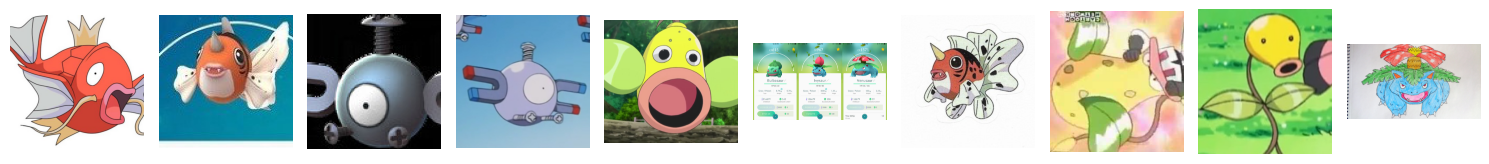

In [29]:
# Plotting 10 images of "bad data"
# Bad data refers to pokemon characters who are wingless species 
# but have features that is similar to wings
bad_class_list = class_list[class_list['Bad_Data'] == 1]['Pokemon']
bad_image_paths = []
valid_extensions = ['.jpg', '.jpeg', '.png']

for folder in bad_class_list:
    bad_image_names = os.listdir(os.path.join(path,folder))
    for image in bad_image_names:
        file_extension = os.path.splitext(image)[1]
        if file_extension not in valid_extensions:
            print(file_extension)
            continue
        bad_image_path = os.path.join(path,folder,image)
        bad_image_paths.append(bad_image_path)
bad_random_list = np.random.choice(bad_image_paths, 10, replace=False)

plt.figure(figsize=(15, 10))
for i,image_path in enumerate(bad_random_list):  
    with Image.open(image_path) as img:
        plt.subplot(1, 10, i + 1)  
        plt.imshow(img)
        plt.axis('off')  
plt.tight_layout()
plt.show()

### Observation: There are pokemon characters who are wingless species but have features that is similar to wings in our dataset. We can drop these "bad data" to make our work easier.

In [30]:
# Removing all classes with bad data
class_list = class_list[class_list['Bad_Data'] != 1]

In [31]:
# Getting Pokemons that are winged and not winged
winged = class_list[class_list['Winged'] == 1]
winged = winged['Pokemon']
not_winged = class_list[class_list['Not_Winged'] == 1]
not_winged = not_winged['Pokemon']

In [32]:
# Making a data frame that has the image paths and their classifcation
images = []
wrong_extensions = []

for folder in winged:
    image_names = os.listdir(os.path.join(path,folder))
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        # Sanity check to make sure all file paths exist
        if file_extension not in valid_extensions:
            wrong_extensions.append(file_extension)
            continue
        image_path = os.path.join(path,folder,image)
        if not os.path.exists(image_path):
            print(image_path)
            continue
        with Image.open(image_path) as img:
            img = np.array(img)
            images.append({'Image': img, 'Source': 'Winged'})
            
for folder in not_winged:
    image_names = os.listdir(os.path.join(path,folder))
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        # Sanity check to make sure all file paths exist
        if file_extension not in valid_extensions:
            wrong_extensions.append(file_extension)
            continue
        image_path = os.path.join(path,folder,image)
        if not os.path.exists(image_path):
            print(image_path)
            continue
        with Image.open(image_path) as img:
            img = np.array(img)
            images.append({'Image': img, 'Source': 'Not Winged'})
            
df = pd.DataFrame(images)
set(wrong_extensions)

{'.asp',
 ".jpg')",
 '.jpg~c200',
 '.sb-334870d9-FK2TVI',
 '.sb-334870d9-nlD60H',
 '.svg'}

### Observation: There are some image data in formats that can't be read by PIL(Python Imaging Library), so that we need to ignore them.

In [33]:
# Sanity check to make sure there are only 2 classes
for index, row in df.iterrows():
    if row['Source'] not in ['Winged', 'Not Winged']:
        print(row)

Dataframe shape: (6017, 2)
Source
Not Winged    5220
Winged         797
Name: count, dtype: int64


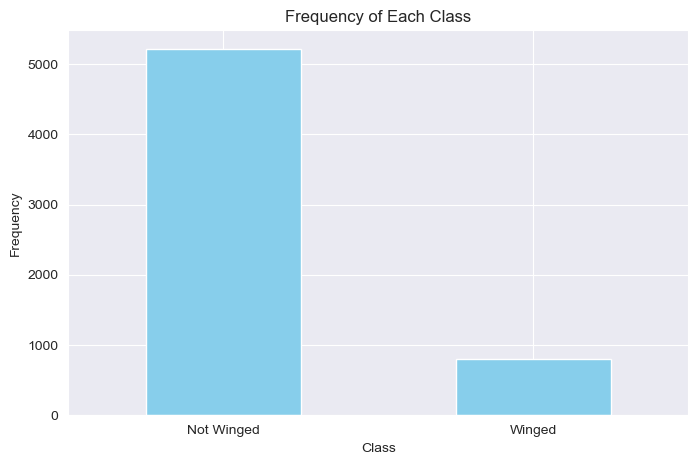

In [34]:
# Plotting frequencies of classes to check for data imbalance
source_counts = df['Source'].value_counts()
plt.figure(figsize=(8, 5))
source_counts.plot(kind='bar', color='skyblue')
plt.title("Frequency of Each Class")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)  
print("Dataframe shape:",df.shape)
print(source_counts)
plt.show()

### Observation: Not Winged class has way more examples than Winged, We'd either have to sample equal number of images from both sets or use a weight balanced optimizer

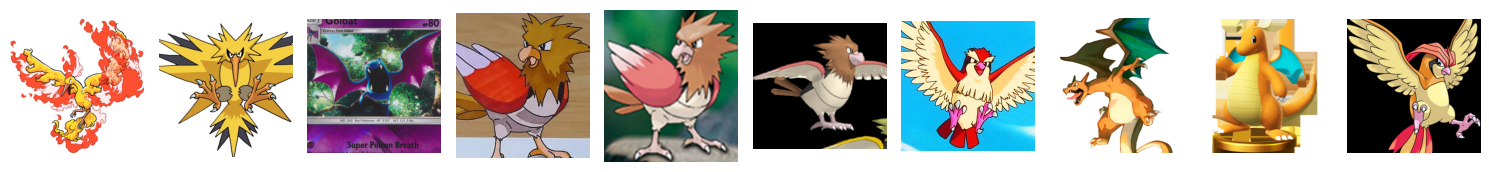

In [35]:
# plotting example classes of the winged image
Winged_random_list = np.random.choice(df[df['Source']=='Winged']['Image'], 10, replace=False)
plt.figure(figsize=(15, 10))
for i,img in enumerate(Winged_random_list):
        plt.subplot(1, 10, i + 1)  
        plt.imshow(img)
        plt.axis('off')  
plt.tight_layout()
plt.show()

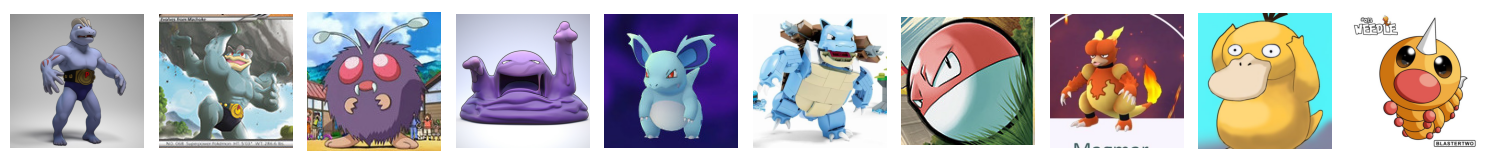

In [36]:
# plotting example classes of the not winged image
NWinged_random_list = np.random.choice(df[df['Source']=='Not Winged']['Image'], 10, replace=False)
plt.figure(figsize=(15, 10))
for i,img in enumerate(NWinged_random_list):
        plt.subplot(1, 10, i + 1)  
        plt.imshow(img)
        plt.axis('off')  
plt.tight_layout()
plt.show()

In [37]:
# Observing data shape
for i in np.random.choice(df['Image'].shape[0],size=10, replace=False):
    print(df['Image'][i].shape)

(874, 862, 3)
(800, 800, 3)
(1050, 1044, 3)
(875, 913, 3)
(126, 126, 3)
(480, 480, 3)
(219, 221, 3)
(881, 887, 3)
(503, 502, 3)
(789, 916, 3)


### Observation: Our image data consists of image tensors with a shape format of (height, width, RGB)

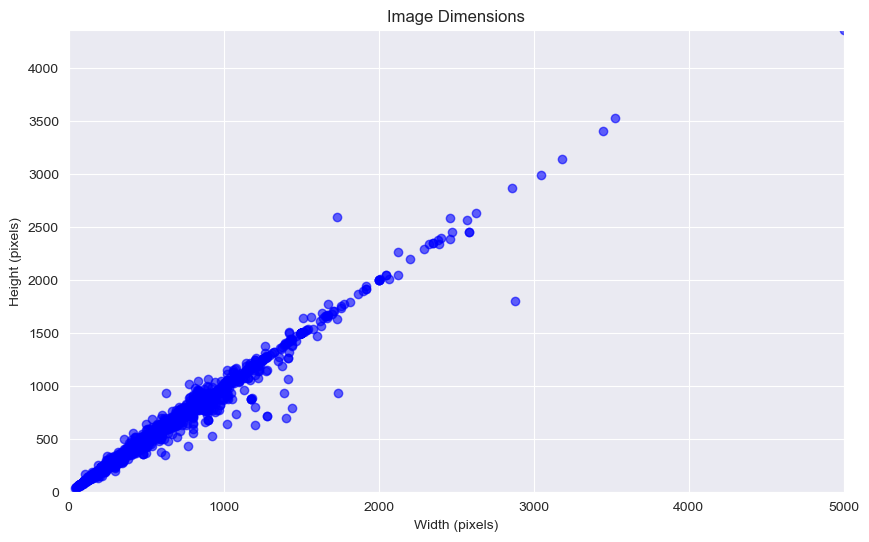

In [38]:
# Plotting the image pixel values
widths = []
heights = []

for img in df['Image']:
            widths.append(img.shape[1])
            heights.append(img.shape[0])

plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, color='blue', alpha=0.6)
plt.title("Image Dimensions")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.xlim(0, max(widths))  
plt.ylim(0, max(heights))  
plt.show()

### Observation: The dimensions of images are varying, we'd have to resize all of them to a common size

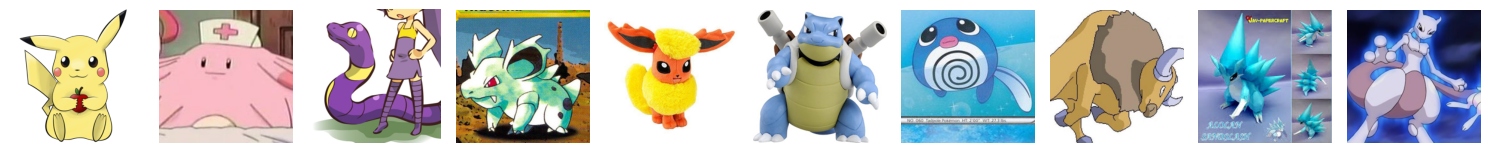

In [39]:
# Plotting 10 images after they've been resized
new_size = (224, 224)
resized_images = []

random_list = np.random.choice(df['Image'], 10, replace=False)

for img in random_list:
    resized_img = Image.fromarray(img).resize(new_size)
    resized_images.append(resized_img)

plt.figure(figsize=(15, 10))
for i, resized_img in enumerate(resized_images):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(resized_img)
    plt.axis('off')  
plt.tight_layout()
plt.show()

### Observation: After resizing, the image retains its prominent features, so we can expect a good fit. 

After ploting multiple random images of the Pokemon characters, we learned that the images of characters various in the style of visual representation.
- 3D rendering
- Plush photos
- Pokemon card
- Cartoon/anime
- Drawing
- Pokemon Go
- Realistic background
- Empty/single color background

### Therefore, we need to normalize the image data to eliminate the effect of different backgrounds on feature extraction.

There are also variations in the depictions of the pokemon:
- orientation
- shape
- for some pokemon, there may be special forms that make it hard to distinguish
- there is possibility for occlusion
- inclusion of English text

However, generally, the pokemon is centered in the image and is the main object.

# Data Preprocessing

In [40]:
# Arrays to store flattened images and their classifications
X = []
y = []

In [41]:
# Normalizing function
def zscore(img):
    mean = img.mean(axis=(0, 1), keepdims=True)
    std = img.std(axis=(0, 1), keepdims=True)
    img = (img - mean) / std
    return img

def minmax(img):
    mean = img.mean(axis=(0, 1), keepdims=True)
    max = img.max(axis=(0, 1), keepdims=True)
    min = img.min(axis=(0, 1), keepdims=True)
    img = (img - min) / (max - min)
    return img

In [42]:
# Going through all images and resizing them, converting them to grayscale and normalizing pixel values
new_size = (224, 224)
for index, row in df.iterrows():
    # Resize images to 224 x 224
    img = Image.fromarray(row['Image']).resize(new_size)
    # Convert images to grayscale
    img = img.convert('L') 
    # Normalize pixel values
    img = np.array(img) / 255.0
    
    # Zscore
    # img = zscore(img)
    # Or
    # # Minmax
    # img = minmax(img)

    X.append(img)
    y.append(1 if row['Source'] == 'Winged' else 0)
X = np.array(X)
y = np.array(y)

In [43]:
X.shape

(6017, 224, 224)

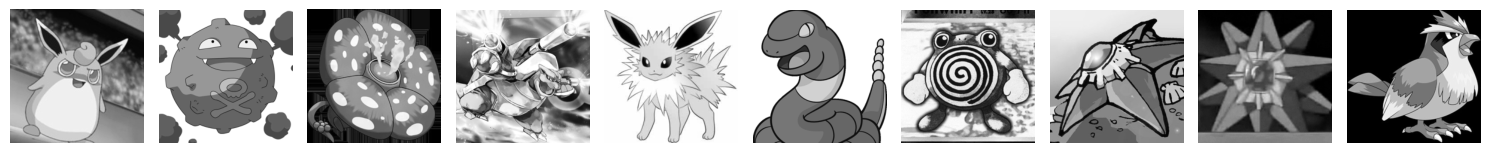

In [44]:
# Plotting 10 images after grayscale and normalizing
X_random_id = np.random.choice(X.shape[0], 10, replace=False)
X_random = X[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img, cmap='gray') 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [45]:
######## We can also use some optimization methods to train on imbalanced dataset ########
# Balancing the data set by random sampling
id_not_winged = np.where(y == 0)[0]
id_winged = np.where(y == 1)[0]
sample_not_winged = np.random.choice(id_not_winged, size=600, replace=False)
sample_winged = np.random.choice(id_winged, size=600, replace=False)
sample = np.concatenate((sample_not_winged, sample_winged), axis=0)
X = X[sample]
y = y[sample]
######## We can also use some optimization methods to train on imbalanced dataset ########

# Creating Train/Validate/Test splits (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
X_train.shape, X_val.shape, X_test.shape

((960, 224, 224), (120, 224, 224), (120, 224, 224))

In [46]:
# Augmentation function
# Our resized image doesn't have enough space for shearing or zooming
def augmentation(img,img_size=(224,224),horizontal_flip=True,vertical_flip=True,rotation_range=15, horizontal_shift=0.1, vertical_shift=0.1):
    # Flipping
    if horizontal_flip and np.random.random() < 0.5:
        img = np.fliplr(img)
    if vertical_flip and np.random.random() < 0.5:
        img = np.flipud(img)
    # Rotating
    if rotation_range > 0:
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)
        rotation_range = np.random.randint(-rotation_range, rotation_range)
        img = img.rotate(rotation_range, resample=Image.BICUBIC,fillcolor=np.mean(img))
    # Shifting
    if horizontal_shift > 0 or vertical_shift > 0:
        w , h = img_size
        dw = np.random.randint(-horizontal_shift * w, horizontal_shift * w)
        dh = np.random.randint(-vertical_shift * h, vertical_shift * h)
        img = ImageOps.expand(img, border=(abs(dw),abs(dh),abs(dw),abs(dh)),fill=np.mean(img))
        img = img.crop((dw+abs(dw),dh+abs(dh),dw+abs(dw)+w,dh+abs(dh)+h))
    # Ensure the sizes
    img = img.resize(img_size)
    return img

In [47]:
# Going through all images and augment them
X_augmented = []
for img in X_train:
    img = augmentation(img)
    X_augmented.append(img)
X_train = np.array(X_augmented)

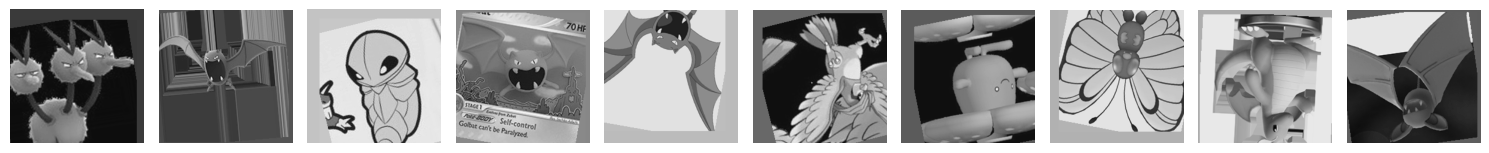

In [48]:
# Plotting 10 images after augmenting
X_random_id = np.random.choice(X_train.shape[0], 10, replace=False)
X_random = X_train[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img, cmap='gray') 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [49]:
X_train.shape, X_val.shape, X_test.shape

((960, 224, 224), (120, 224, 224), (120, 224, 224))

# Model Training

## Logistic Regression

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       480
           1       1.00      1.00      1.00       480

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960

              precision    recall  f1-score   support

           0       0.52      0.43      0.47        60
           1       0.51      0.60      0.55        60

    accuracy                           0.52       120
   macro avg       0.52      0.52      0.51       120
weighted avg       0.52      0.52      0.51       120



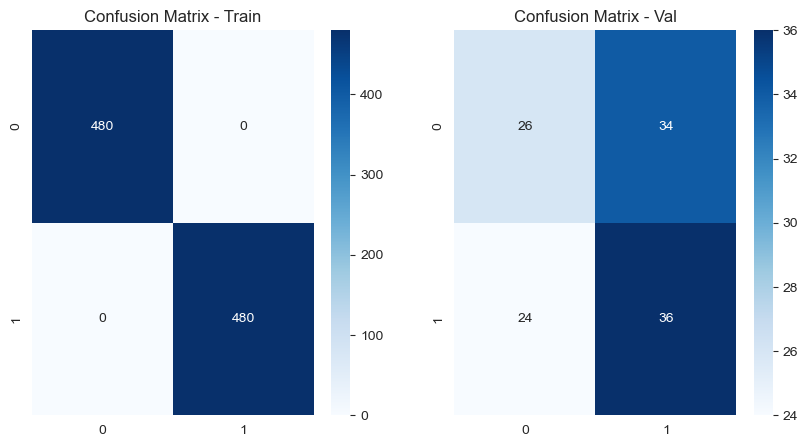

In [50]:
X_flattened_train = X_train.reshape(X_train.shape[0], -1)
X_flattened_val = X_test.reshape(X_val.shape[0], -1)
X_flattened_test = X_test.reshape(X_test.shape[0], -1)

LR = LogisticRegression(max_iter=1000)
LR.fit(X_flattened_train, y_train)

y_logistic_train_pred = LR.predict(X_flattened_train)
print(classification_report(y_train,y_logistic_train_pred))
cm_train = confusion_matrix(y_train,y_logistic_train_pred)

y_logistic_val_pred = LR.predict(X_flattened_val)
print(classification_report(y_val,y_logistic_val_pred))
cm_val = confusion_matrix(y_val,y_logistic_val_pred)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.subplot(1, 2, 2)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Val')
plt.show()

## Naive Bayes

              precision    recall  f1-score   support

           0       0.55      0.69      0.61       480
           1       0.59      0.45      0.51       480

    accuracy                           0.57       960
   macro avg       0.57      0.57      0.56       960
weighted avg       0.57      0.57      0.56       960

              precision    recall  f1-score   support

           0       0.51      0.58      0.55        60
           1       0.52      0.45      0.48        60

    accuracy                           0.52       120
   macro avg       0.52      0.52      0.51       120
weighted avg       0.52      0.52      0.51       120



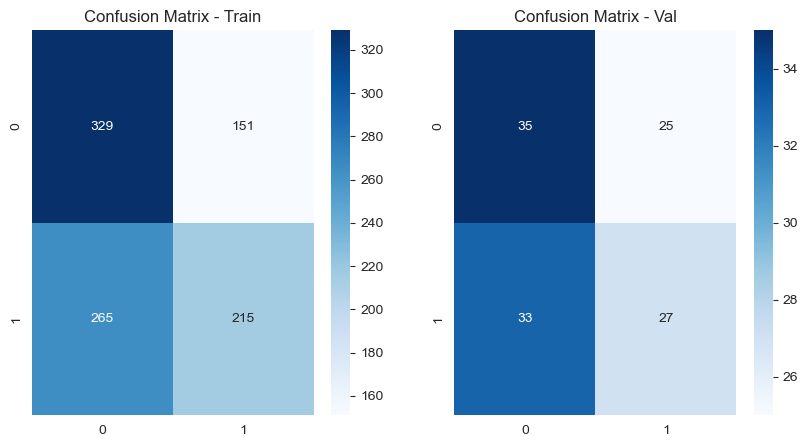

In [51]:
NB = GaussianNB()
NB.fit(X_flattened_train, y_train)

y_bayes_train_pred = NB.predict(X_flattened_train)
print(classification_report(y_train,y_bayes_train_pred))
cm_train = confusion_matrix(y_train,y_bayes_train_pred)

y_bayes_val_pred = NB.predict(X_flattened_val)
print(classification_report(y_val,y_bayes_val_pred))
cm_val = confusion_matrix(y_val,y_bayes_val_pred)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.subplot(1, 2, 2)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Val')
plt.show()

## SVM

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       480
           1       1.00      1.00      1.00       480

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960

              precision    recall  f1-score   support

           0       0.55      0.48      0.51        60
           1       0.54      0.60      0.57        60

    accuracy                           0.54       120
   macro avg       0.54      0.54      0.54       120
weighted avg       0.54      0.54      0.54       120



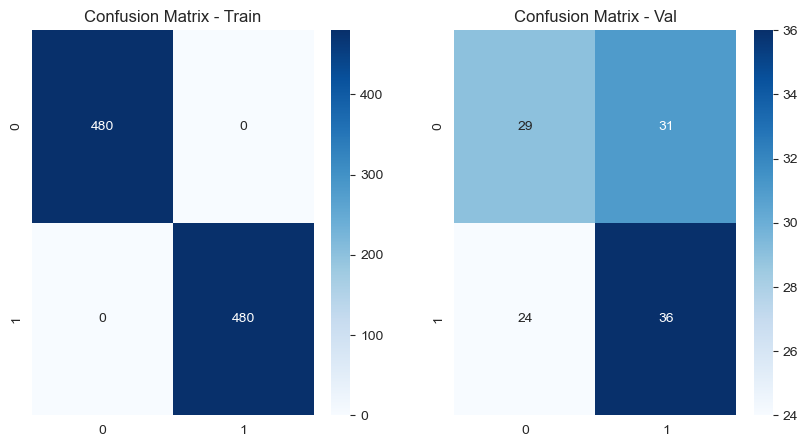

In [52]:
svm_linear = SVC(kernel = 'linear')
svm_linear.fit(X_flattened_train, y_train)

y_svm_linear_train_pred = svm_linear.predict(X_flattened_train)
print(classification_report(y_train,y_svm_linear_train_pred))
cm_train = confusion_matrix(y_train,y_svm_linear_train_pred)

y_svm_linear_val_pred = svm_linear.predict(X_flattened_val)
print(classification_report(y_val,y_svm_linear_val_pred))
cm_val = confusion_matrix(y_val,y_svm_linear_val_pred)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.subplot(1, 2, 2)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Val')
plt.show()

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       480
           1       0.89      0.89      0.89       480

    accuracy                           0.89       960
   macro avg       0.89      0.89      0.89       960
weighted avg       0.89      0.89      0.89       960

              precision    recall  f1-score   support

           0       0.48      0.55      0.51        60
           1       0.47      0.40      0.43        60

    accuracy                           0.47       120
   macro avg       0.47      0.48      0.47       120
weighted avg       0.47      0.47      0.47       120



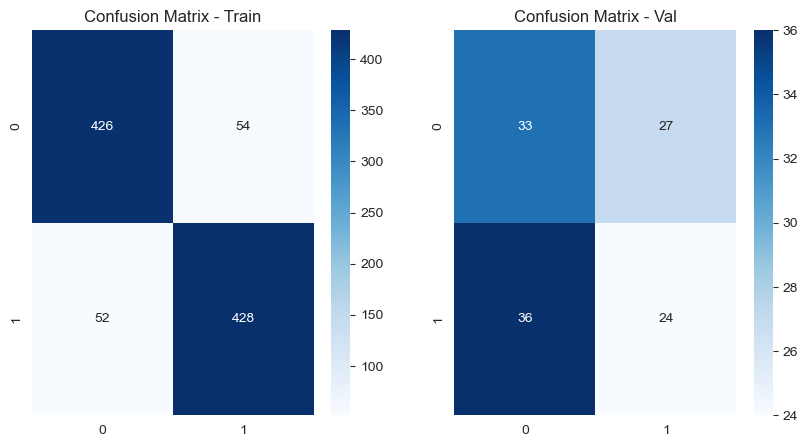

In [53]:
svm_rbf = SVC(kernel = 'rbf')
svm_rbf.fit(X_flattened_train, y_train)

y_svm_rbf_train_pred = svm_rbf.predict(X_flattened_train)
print(classification_report(y_train,y_svm_rbf_train_pred))
cm_train = confusion_matrix(y_train,y_svm_rbf_train_pred)

y_svm_rbf_val_pred = svm_rbf.predict(X_flattened_val)
print(classification_report(y_val,y_svm_rbf_val_pred))
cm_val = confusion_matrix(y_val,y_svm_rbf_val_pred)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.subplot(1, 2, 2)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Val')
plt.show()



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       480
           1       1.00      1.00      1.00       480

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960

              precision    recall  f1-score   support

           0       0.46      0.47      0.46        60
           1       0.46      0.45      0.45        60

    accuracy                           0.46       120
   macro avg       0.46      0.46      0.46       120
weighted avg       0.46      0.46      0.46       120



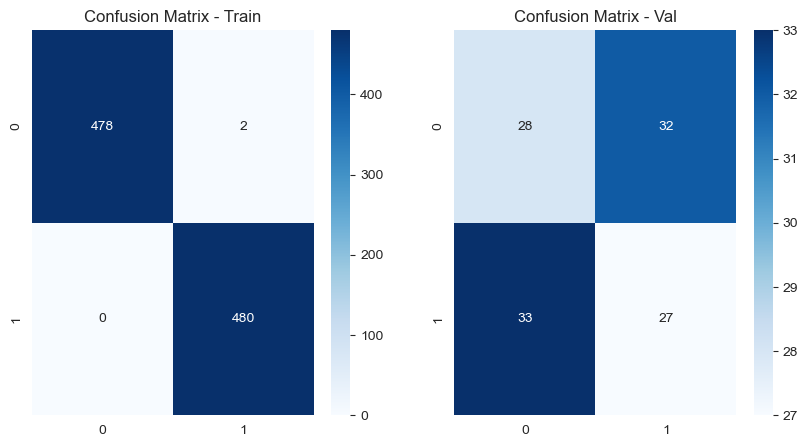

In [54]:
svm_poly = SVC(kernel = 'poly')
svm_poly.fit(X_flattened_train, y_train)

y_svm_poly_train_pred = svm_poly.predict(X_flattened_train)
print(classification_report(y_train,y_svm_poly_train_pred))
cm_train = confusion_matrix(y_train,y_svm_poly_train_pred)

y_svm_poly_val_pred = svm_poly.predict(X_flattened_val)
print(classification_report(y_val,y_svm_poly_val_pred))
cm_val = confusion_matrix(y_val,y_svm_poly_val_pred)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.subplot(1, 2, 2)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Val')
plt.show()

              precision    recall  f1-score   support

           0       0.51      0.52      0.52       480
           1       0.51      0.50      0.51       480

    accuracy                           0.51       960
   macro avg       0.51      0.51      0.51       960
weighted avg       0.51      0.51      0.51       960

              precision    recall  f1-score   support

           0       0.57      0.60      0.59        60
           1       0.58      0.55      0.56        60

    accuracy                           0.57       120
   macro avg       0.58      0.57      0.57       120
weighted avg       0.58      0.57      0.57       120



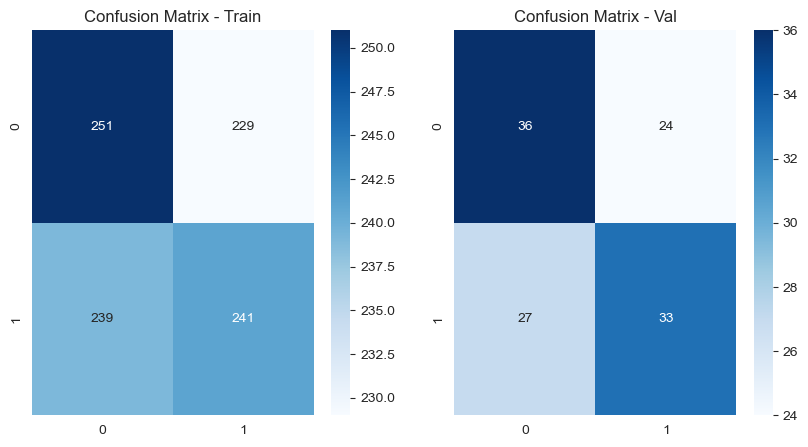

In [55]:
svm_sigmoid = SVC(kernel = 'sigmoid')
svm_sigmoid.fit(X_flattened_train, y_train)

y_svm_sigmoid_train_pred = svm_sigmoid.predict(X_flattened_train)
print(classification_report(y_train,y_svm_sigmoid_train_pred))
cm_train = confusion_matrix(y_train,y_svm_sigmoid_train_pred)

y_svm_sigmoid_val_pred = svm_sigmoid.predict(X_flattened_val)
print(classification_report(y_val,y_svm_sigmoid_val_pred))
cm_val = confusion_matrix(y_val,y_svm_sigmoid_val_pred)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.subplot(1, 2, 2)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Val')
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       480
           1       1.00      1.00      1.00       480

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960

              precision    recall  f1-score   support

           0       0.55      0.48      0.51        60
           1       0.54      0.60      0.57        60

    accuracy                           0.54       120
   macro avg       0.54      0.54      0.54       120
weighted avg       0.54      0.54      0.54       120



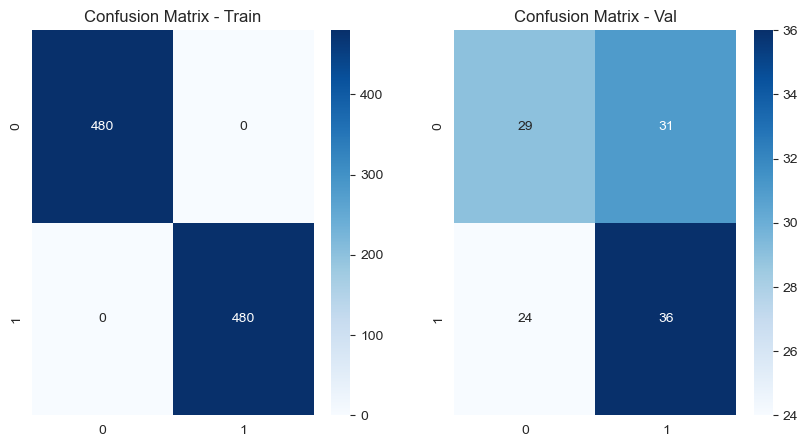

In [56]:
from sklearn.metrics.pairwise import linear_kernel
K_train = linear_kernel(X_flattened_train, X_flattened_train)
K_val = linear_kernel(X_flattened_val, X_flattened_train)
svm_precomputed = SVC(kernel = 'precomputed')
svm_precomputed.fit(K_train, y_train)

y_svm_precomputed_train_pred = svm_precomputed.predict(K_train)
print(classification_report(y_train,y_svm_precomputed_train_pred))
cm_train = confusion_matrix(y_train,y_svm_precomputed_train_pred)

y_svm_precomputed_val_pred = svm_precomputed.predict(K_val)
print(classification_report(y_val,y_svm_precomputed_val_pred))
cm_val = confusion_matrix(y_val,y_svm_precomputed_val_pred)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.subplot(1, 2, 2)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Val')
plt.show()

## KNN

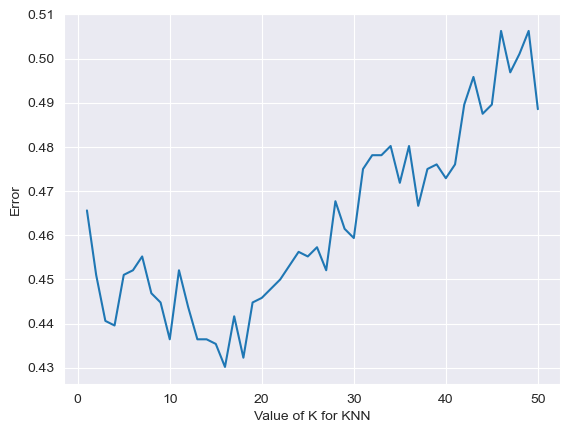

In [57]:
# Picking suitable value of k
from sklearn.model_selection import cross_val_score
k_range = range(1, 51)
k_error = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_flattened_train, y_train, cv=6, scoring='accuracy', verbose=1)
    k_error.append(1 - scores.mean())
plt.plot(k_range, k_error)
plt.xlabel('Value of K for KNN')
plt.ylabel('Error')
plt.show()


              precision    recall  f1-score   support

           0       0.67      0.60      0.64       480
           1       0.64      0.71      0.67       480

    accuracy                           0.66       960
   macro avg       0.66      0.66      0.65       960
weighted avg       0.66      0.66      0.65       960

              precision    recall  f1-score   support

           0       0.53      0.65      0.59        60
           1       0.55      0.43      0.49        60

    accuracy                           0.54       120
   macro avg       0.54      0.54      0.54       120
weighted avg       0.54      0.54      0.54       120



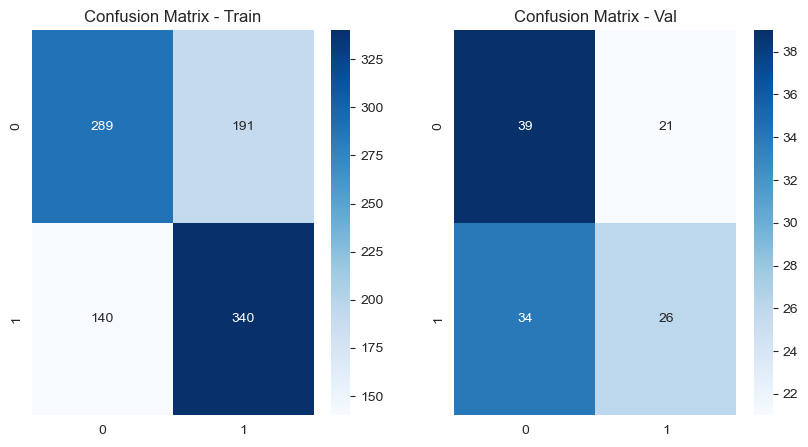

In [58]:
k=16
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_flattened_train, y_train)

y_knn_train_pred = knn.predict(X_flattened_train)
print(classification_report(y_train,y_knn_train_pred))
cm_train = confusion_matrix(y_train,y_knn_train_pred)

y_knn_val_pred = knn.predict(X_flattened_val)
print(classification_report(y_val,y_knn_val_pred))
cm_val = confusion_matrix(y_val,y_knn_val_pred)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.subplot(1, 2, 2)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Val')
plt.show()


## CNN

In [70]:
class CNN(nn.Module):
    def __init__(self,image_size=(224,224), num_classes=2):
        super(CNN, self).__init__()
        h,w = image_size
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flattened_size = 128 * h * w //16
        self.fc = nn.Linear(self.flattened_size, num_classes)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

cuda
Epoch [1/32], Step [1/30], Loss: 0.6947
Epoch [1/32], Step [11/30], Loss: 1.0585
Epoch [1/32], Step [21/30], Loss: 0.6910
Epoch [2/32], Step [1/30], Loss: 0.6848
Epoch [2/32], Step [11/30], Loss: 0.6795
Epoch [2/32], Step [21/30], Loss: 0.6820
Epoch [3/32], Step [1/30], Loss: 0.6659
Epoch [3/32], Step [11/30], Loss: 0.6897
Epoch [3/32], Step [21/30], Loss: 0.6763
Epoch [4/32], Step [1/30], Loss: 0.6107
Epoch [4/32], Step [11/30], Loss: 0.6765
Epoch [4/32], Step [21/30], Loss: 0.6525
Epoch [5/32], Step [1/30], Loss: 0.5407
Epoch [5/32], Step [11/30], Loss: 0.5323
Epoch [5/32], Step [21/30], Loss: 0.5949
Epoch [6/32], Step [1/30], Loss: 0.4553
Epoch [6/32], Step [11/30], Loss: 0.3100
Epoch [6/32], Step [21/30], Loss: 0.5166
Epoch [7/32], Step [1/30], Loss: 0.3763
Epoch [7/32], Step [11/30], Loss: 0.2741
Epoch [7/32], Step [21/30], Loss: 0.1846
Epoch [8/32], Step [1/30], Loss: 0.2277
Epoch [8/32], Step [11/30], Loss: 0.1760
Epoch [8/32], Step [21/30], Loss: 0.3085
Epoch [9/32], Step 

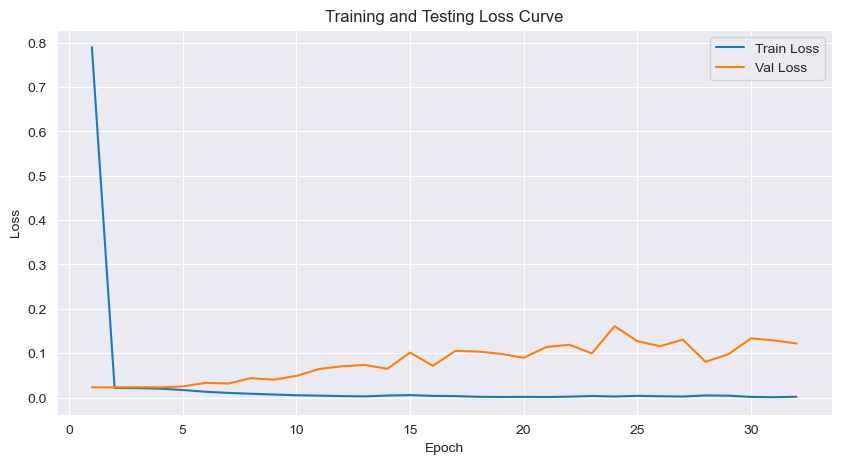

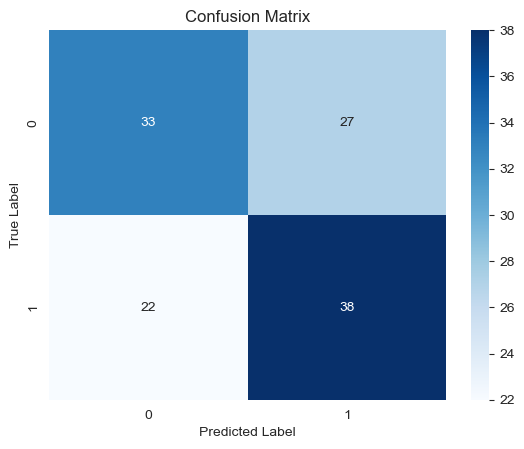

In [71]:
torch.manual_seed(2024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
CNN = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(CNN.parameters(),lr=0.01,weight_decay=1e-4)

epoches = 32
datas = []
val_datas = []

# Create DataLoaders for training and testing
dataset = TensorDataset(torch.tensor(X_train,dtype=torch.float32).unsqueeze(1), torch.tensor(y_train,dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val,dtype=torch.float32).unsqueeze(1), torch.tensor(y_val,dtype=torch.long))
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

#################################1      
train_losses = []
val_losses = []
#################################1   

CNN.train()

for epoch in range(epoches):
#################################2  
    train_loss = 0.0
    val_loss = 0.0
#################################2           
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = CNN(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # if epoch%100==0 and i%10==0:
        if i%10==0:
                print(f'Epoch [{epoch+1}/{epoches}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
#################################3            
        train_loss += loss.item()

    train_loss /= len(y_train)
    train_losses.append(train_loss)

    for i, (val_inputs, val_targets) in enumerate(val_loader):
        val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
        val_outputs = CNN(val_inputs)
        v_loss = criterion(val_outputs, val_targets)
        val_loss += v_loss.item()
    val_loss /= len(y_val)
    val_losses.append(val_loss)
#################################3
# evaluate model
CNN.eval()
all_targets = []
all_predictions = []

# for epoch in range(epoches):
with torch.no_grad():
    for i, (val_inputs, val_targets) in enumerate(val_loader):
        val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
        val_outputs = CNN(val_inputs)
        _, val_predicted = torch.max(val_outputs, 1)
        all_targets.extend(val_targets.cpu().numpy())
        all_predictions.extend(val_predicted.cpu().numpy())


#########################4
# loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curve')
plt.legend()
# plt.savefig(f'loss_curve_sub_{sub + 1}.png')
plt.show()
##########################4

# calculate confusion matrix
cm = confusion_matrix(all_targets, all_predictions)
# plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
# plt.savefig(f'confusion_matrix_sub_{sub + 1}.png')
plt.show()



In [74]:
print(classification_report(all_targets, all_predictions))

              precision    recall  f1-score   support

           0       0.60      0.55      0.57        60
           1       0.58      0.63      0.61        60

    accuracy                           0.59       120
   macro avg       0.59      0.59      0.59       120
weighted avg       0.59      0.59      0.59       120

